In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

## Import data

In [2]:
df = pd.read_csv('column_2C_weka.csv')

In [3]:
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [4]:
df.shape

(310, 7)

## EDA

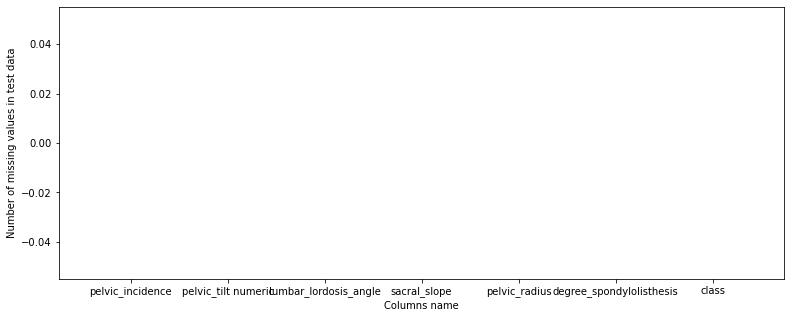

In [5]:
# Missing data in dataset
plt.figure(figsize = (13,5))
plt.bar(df.columns, df.isnull().sum().values, color = 'red')
plt.xlabel("Columns name")
plt.ylabel("Number of missing values in test data")
plt.show()

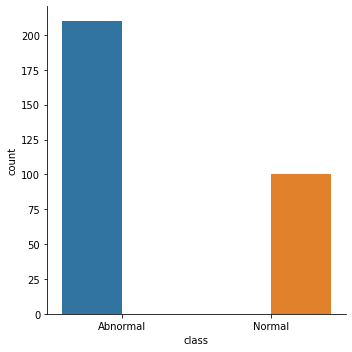

In [6]:
# Output data distribution
sns.catplot(x='class', hue='class', data=df, kind="count")

## Data preprocessing

In [7]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [8]:
Y = [1 if each == "Abnormal" else 0 for each in y]

In [9]:
scaler = MinMaxScaler()
scaler.fit(x)
X = scaler.transform(x)

## Divide into train/ val

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)

print(Y_train.shape)
print(Y_val.shape)

(248, 6)
(62, 6)
(248,)
(62,)


## Models

### Neural network

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential

In [13]:
model_nn1 = Sequential([
    Input(shape=(6, )),
    Dense(units=20, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

In [14]:
model_nn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_nn1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer='adam',
)

In [16]:
model_nn1.fit(
    X_train, Y_train,
    epochs=100
)

Epoch 1/100
8/8 [==============================] - 1s 2ms/step - loss: 0.6880
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6748
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6627
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6514
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6406
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6320
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6240
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6158
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6085
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6012
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5943
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5876
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

### Decision forest

In [17]:
from xgboost import XGBClassifier

In [18]:
xgb_model = XGBClassifier(objective="binary:logistic")
xgb_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Decision forest 2 (with hyperparameter tuning)

In [19]:
search_space = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.001, 0.005, 0.01]
}

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
GS = GridSearchCV(
    estimator=xgb_model,
    param_grid=search_space,
    scoring=["r2", "neg_root_mean_squared_error"],
    refit="r2",
    cv=5,
    verbose=4
)

In [22]:
GS.fit(X_train, Y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.469) r2: (test=-0.011) total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.346) r2: (test=0.449) total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.515) r2: (test=-0.206) total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.404) r2: (test=0.258) total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=200; neg_root_mean_squared_error: (test=-0.424) r2: (test=0.173) total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=200; neg_roo

[CV 3/5] END learning_rate=0.005, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.316) r2: (test=0.540) total time=   0.1s
[CV 4/5] END learning_rate=0.005, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.474) r2: (test=-0.021) total time=   0.1s
[CV 5/5] END learning_rate=0.005, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.429) r2: (test=0.165) total time=   0.1s
[CV 1/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.0s
[CV 2/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.0s
[CV 3/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.283) r2: (test=0.632) total time=   0.0s
[CV 4/5] END learning_rate=0.005, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.474) r2: (test=-0.021) total tim

[CV 1/5] END learning_rate=0.01, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.424) r2: (test=0.173) total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.346) r2: (test=0.449) total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.452) r2: (test=0.072) total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.429) r2: (test=0.165) total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.346) r2: (test=0.449) total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.374) r2: (test=0.357) total time=   0.0s

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.001, 0.005, 0.01],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 500]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=4)

In [23]:
print(GS.best_score_)

0.29808377896613203


In [24]:
print(GS.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


In [25]:
xgb_model2 = XGBClassifier(objective="binary:logistic", learning_rate=0.01, max_depth=3, n_estimators=500)

In [26]:
xgb_model2.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Neural network 2 with hyperparameter tuning

In [27]:
def create_nn_model(neurons=1, neurons2=2, activation='relu'):
    nn = Sequential([
        Input(shape=(6, )),
        Dense(units = neurons, activation = activation),
        Dropout(0.1),
        Dense(units = neurons2, activation = activation),
        Dense(units = 1, activation="sigmoid")
    ])
    nn.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    return nn

In [28]:
from scikeras.wrappers import KerasClassifier

In [29]:
model_nn2 = KerasClassifier(build_fn=create_nn_model, epochs=100, verbose=1, neurons=[2, 8, 16, 32], neurons2=[2, 8, 16])

In [115]:
searchspace_2 = {
    'neurons': [2, 8, 16, 32],
    'neurons2': [2, 8, 16],
    'batch_size': [32, 64, 128],
}

In [116]:
GS2 = GridSearchCV(
    estimator=model_nn2,
    param_grid=searchspace_2,
    cv=3,
    n_jobs=1
)

In [117]:
model_nn2.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'neurons', 'neurons2', 'class_weight'])

In [118]:
GS2.fit(X_train, Y_train)

Epoch 1/100


/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.6424
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.6458 - accuracy: 0.6788
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6455 - accuracy: 0.6788
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6452 - accuracy: 0.6788
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6449 - accuracy: 0.6788
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6447 - accuracy: 0.6788
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6445 - accuracy: 0.6788
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6441 - accuracy: 0.6788
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6438 - accuracy: 0.6788
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6435 - accuracy: 0.6788
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6432 - accuracy: 0.6788
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 2ms/step - loss: 0.7230 - accuracy: 0.3152
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7199 - accuracy: 0.2485
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7133 - accuracy: 0.3212
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7074 - accuracy: 0.4000
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7055 - accuracy: 0.3818
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7010 - accuracy: 0.4424
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6992 - accuracy: 0.4909
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.5091
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.5515
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5758
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.6463 - accuracy: 0.6788
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6460 - accuracy: 0.6788
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6456 - accuracy: 0.6788
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6454 - accuracy: 0.6788
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6450 - accuracy: 0.6788
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6447 - accuracy: 0.6788
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6445 - accuracy: 0.6788
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6441 - accuracy: 0.6788
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6439 - accuracy: 0.6788
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6435 - accuracy: 0.6788
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.6687
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.6747
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.6747
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.6747
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.6747
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.6747
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6801 - accuracy: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6784 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6757 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.6067 - accuracy: 0.6747
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6120 - accuracy: 0.6747
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6162 - accuracy: 0.6747
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6088 - accuracy: 0.6747
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6747
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6010 - accuracy: 0.6747
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6073 - accuracy: 0.6747
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6053 - accuracy: 0.6747
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6113 - accuracy: 0.6747
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6066 - accuracy: 0.6747
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.6606
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6687 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6657 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5787 - accuracy: 0.6788
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5719 - accuracy: 0.6788
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5827 - accuracy: 0.6788
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5721 - accuracy: 0.6788
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5657 - accuracy: 0.6788
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.6788
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5727 - accuracy: 0.6788
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5717 - accuracy: 0.6788
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5800 - accuracy: 0.6788
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5692 - accuracy: 0.6788
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7446 - accuracy: 0.3273
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7392 - accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.7362 - accuracy: 0.3394
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7277 - accuracy: 0.3697
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7256 - accuracy: 0.3333
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.7222 - accuracy: 0.3212
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7159 - accuracy: 0.3576
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7111 - accuracy: 0.3273
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.3273
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - loss: 0.7058 - accuracy: 0.3758
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6788
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6788
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6788
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6788
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6788
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6788
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6788
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6788
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6788
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6788
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7258 - accuracy: 0.3675
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7240 - accuracy: 0.3735
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7221 - accuracy: 0.3554
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7248 - accuracy: 0.3253
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.4036
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.3675
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.3795
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.4036
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.4458
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.4880
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5959 - accuracy: 0.6747
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5810 - accuracy: 0.6747
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5824 - accuracy: 0.6747
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5873 - accuracy: 0.6747
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5822 - accuracy: 0.6747
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5778 - accuracy: 0.6747
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5782 - accuracy: 0.6747
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5770 - accuracy: 0.6747
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5798 - accuracy: 0.6747
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5788 - accuracy: 0.6747
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7700 - accuracy: 0.2667
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7624 - accuracy: 0.2727
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.7509 - accuracy: 0.2424
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7371 - accuracy: 0.3212
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.3333
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.4242
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.4545
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.4970
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5515
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.6061
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5621 - accuracy: 0.6788
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5577 - accuracy: 0.6788
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5539 - accuracy: 0.6788
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5435 - accuracy: 0.6788
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5509 - accuracy: 0.6788
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5693 - accuracy: 0.6788
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5539 - accuracy: 0.6788
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5492 - accuracy: 0.6788
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5473 - accuracy: 0.6788
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5571 - accuracy: 0.6788
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.6727
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5782 - accuracy: 0.6788
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5732 - accuracy: 0.6788
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.6788
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5619 - accuracy: 0.6788
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5756 - accuracy: 0.6788
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5770 - accuracy: 0.6788
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5704 - accuracy: 0.6788
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5820 - accuracy: 0.6788
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5608 - accuracy: 0.6788
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5842 - accuracy: 0.6788
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.6687
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.6747
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.6747
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.6747
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6747
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6747
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5574 - accuracy: 0.6747
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5679 - accuracy: 0.6747
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5527 - accuracy: 0.6747
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5773 - accuracy: 0.6747
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5582 - accuracy: 0.6747
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5690 - accuracy: 0.6747
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5699 - accuracy: 0.6747
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5551 - accuracy: 0.6747
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5691 - accuracy: 0.6747
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5663 - accuracy: 0.6747
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 1s 3ms/step - loss: 0.6622 - accuracy: 0.6424
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6727
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6727
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6182
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6121
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6727
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6667
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6667
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5668 - accuracy: 0.6788
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5600 - accuracy: 0.6788
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5613 - accuracy: 0.6788
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5682 - accuracy: 0.6788
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5586 - accuracy: 0.6788
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5612 - accuracy: 0.6788
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5623 - accuracy: 0.6788
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.6788
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5545 - accuracy: 0.6788
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5651 - accuracy: 0.6788
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7369 - accuracy: 0.3152
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7249 - accuracy: 0.3212
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.3333
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.3758
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.4242
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.4242
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5455
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5333
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5939
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.6848
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6788
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6788
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6788
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6788
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6788
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6788
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6788
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6788
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6788
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6788
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7640 - accuracy: 0.3434
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7383 - accuracy: 0.4096
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7407 - accuracy: 0.3795
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7336 - accuracy: 0.3675
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7264 - accuracy: 0.3494
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4337
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4096
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5482
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.6145
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.6024
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.7711
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5008 - accuracy: 0.7711
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5118 - accuracy: 0.7470
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5101 - accuracy: 0.7530
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4916 - accuracy: 0.7831
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4963 - accuracy: 0.7590
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4883 - accuracy: 0.7651
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.7771
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4834 - accuracy: 0.7771
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5038 - accuracy: 0.7590
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6788
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6099 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.6848
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5998 - accuracy: 0.6909
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6027 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5926 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5942 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.6727
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5033 - accuracy: 0.7394
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4908 - accuracy: 0.7576
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5072 - accuracy: 0.7333
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5169 - accuracy: 0.7394
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5042 - accuracy: 0.7576
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4831 - accuracy: 0.7697
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5102 - accuracy: 0.7455
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4856 - accuracy: 0.7697
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5000 - accuracy: 0.7455
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5217 - accuracy: 0.7333
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6788
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6090 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6070 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5977 - accuracy: 0.6848
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5923 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5820 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5870 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5842 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4694 - accuracy: 0.8061
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4694 - accuracy: 0.7758
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4734 - accuracy: 0.7636
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4646 - accuracy: 0.7697
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4922 - accuracy: 0.7030
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4686 - accuracy: 0.7455
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4783 - accuracy: 0.7576
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4749 - accuracy: 0.7515
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4490 - accuracy: 0.7697
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4688 - accuracy: 0.7455
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.6446
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6265
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6386
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6386
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6506
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6807
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6687
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4954 - accuracy: 0.7229
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4864 - accuracy: 0.7229
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4839 - accuracy: 0.7470
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4833 - accuracy: 0.7349
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4855 - accuracy: 0.7349
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4816 - accuracy: 0.7470
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4817 - accuracy: 0.7108
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4817 - accuracy: 0.7349
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4825 - accuracy: 0.7349
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4905 - accuracy: 0.7349
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.4000
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5394
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.6485
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4832 - accuracy: 0.7697
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4821 - accuracy: 0.7939
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4655 - accuracy: 0.8182
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4743 - accuracy: 0.7939
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4658 - accuracy: 0.7939
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.8242
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4720 - accuracy: 0.7879
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4594 - accuracy: 0.8182
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.8242
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4721 - accuracy: 0.7818
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.3697
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.3515
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.4424
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5333
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.4788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5636
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5879
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.6364
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.6606
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6667
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4950 - accuracy: 0.6727
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4805 - accuracy: 0.6848
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4824 - accuracy: 0.7030
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4719 - accuracy: 0.7030
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.7091
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4662 - accuracy: 0.7273
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4650 - accuracy: 0.7333
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4887 - accuracy: 0.7212
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7212
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4641 - accuracy: 0.7333
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6747
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6747
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6747
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6747
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6747
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6747
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.8072
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4447 - accuracy: 0.8193
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4271 - accuracy: 0.8072
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4495 - accuracy: 0.8012
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.7952
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.8133
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4437 - accuracy: 0.8193
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4531 - accuracy: 0.7952
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4326 - accuracy: 0.8072
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4439 - accuracy: 0.7952
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6788
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6052 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5960 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5916 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5881 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5894 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5850 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5849 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.7818
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4736 - accuracy: 0.7576
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4781 - accuracy: 0.7455
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4713 - accuracy: 0.7576
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4892 - accuracy: 0.7394
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4828 - accuracy: 0.7515
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4782 - accuracy: 0.7515
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4903 - accuracy: 0.7394
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4737 - accuracy: 0.7333
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4862 - accuracy: 0.7455
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6003 - accuracy: 0.6727
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5916 - accuracy: 0.6909
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5932 - accuracy: 0.6909
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.6727
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5799 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5759 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5758 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5697 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5735 - accuracy: 0.6727
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4826 - accuracy: 0.7576
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4845 - accuracy: 0.7697
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4799 - accuracy: 0.7455
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4829 - accuracy: 0.7636
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4798 - accuracy: 0.7455
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4765 - accuracy: 0.7636
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4815 - accuracy: 0.7515
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4718 - accuracy: 0.7697
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4671 - accuracy: 0.7697
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4728 - accuracy: 0.7818
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4217
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5723
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.6566
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6817 - accuracy: 0.6627
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.6627
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.6747
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5498 - accuracy: 0.6747
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5392 - accuracy: 0.6747
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5437 - accuracy: 0.6747
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5426 - accuracy: 0.6747
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5396 - accuracy: 0.6747
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5383 - accuracy: 0.6747
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.6747
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5362 - accuracy: 0.6747
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5329 - accuracy: 0.6747
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5336 - accuracy: 0.6747
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.6485
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.6545
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.6606
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.6667
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6685 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5053 - accuracy: 0.7515
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4860 - accuracy: 0.7818
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.7636
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4855 - accuracy: 0.7515
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4968 - accuracy: 0.7333
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4814 - accuracy: 0.7758
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4911 - accuracy: 0.7333
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4844 - accuracy: 0.7879
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4836 - accuracy: 0.7697
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4822 - accuracy: 0.7758
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5576
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5879
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.6485
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.6545
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.6667
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.5544 - accuracy: 0.6970
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5464 - accuracy: 0.6970
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5419 - accuracy: 0.6848
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5357 - accuracy: 0.7091
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5480 - accuracy: 0.6667
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5407 - accuracy: 0.7091
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5421 - accuracy: 0.7030
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5357 - accuracy: 0.6606
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5386 - accuracy: 0.7030
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5310 - accuracy: 0.7091
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7719 - accuracy: 0.3253
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7476 - accuracy: 0.3253
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7363 - accuracy: 0.3253
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7238 - accuracy: 0.3253
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.3434
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.3795
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.4578
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.6084
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.6928
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4737 - accuracy: 0.7651
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4735 - accuracy: 0.7831
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4645 - accuracy: 0.7771
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4704 - accuracy: 0.7590
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4751 - accuracy: 0.7590
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4685 - accuracy: 0.7651
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4848 - accuracy: 0.7349
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4517 - accuracy: 0.7831
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4684 - accuracy: 0.7651
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4604 - accuracy: 0.7952
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.3697
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.6242
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.7212
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4196 - accuracy: 0.8364
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4223 - accuracy: 0.8242
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4160 - accuracy: 0.8364
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4370 - accuracy: 0.8061
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.7818
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4264 - accuracy: 0.8061
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.7758
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4398 - accuracy: 0.8000
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4308 - accuracy: 0.8000
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4165 - accuracy: 0.8364
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 1s 3ms/step - loss: 0.7565 - accuracy: 0.3273
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7322 - accuracy: 0.3455
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.4182
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5030
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.6424
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6727
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6727
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6727
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6727
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4640 - accuracy: 0.7818
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4478 - accuracy: 0.7879
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4628 - accuracy: 0.7818
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4606 - accuracy: 0.7576
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4490 - accuracy: 0.7576
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4466 - accuracy: 0.7879
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4567 - accuracy: 0.7636
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.7879
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4436 - accuracy: 0.7758
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4652 - accuracy: 0.7636
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.4578
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5602
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6627
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.6325
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6386
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6807
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4804 - accuracy: 0.7410
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4631 - accuracy: 0.7711
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4867 - accuracy: 0.7229
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4546 - accuracy: 0.7771
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4667 - accuracy: 0.7651
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.7651
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4660 - accuracy: 0.7651
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4706 - accuracy: 0.7590
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4680 - accuracy: 0.7229
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4579 - accuracy: 0.7590
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6788
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5978 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5845 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5892 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5833 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5819 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5686 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5619 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4581 - accuracy: 0.8000
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4635 - accuracy: 0.7879
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.7758
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4614 - accuracy: 0.7818
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.7939
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4588 - accuracy: 0.7939
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.7879
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4641 - accuracy: 0.7879
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4619 - accuracy: 0.7576
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4601 - accuracy: 0.7697
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6727
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6127 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6055 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5936 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5959 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5953 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5893 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.4817 - accuracy: 0.7333
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4675 - accuracy: 0.7515
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4656 - accuracy: 0.7636
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4697 - accuracy: 0.7515
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7636
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4749 - accuracy: 0.7576
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4663 - accuracy: 0.7333
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.7576
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4592 - accuracy: 0.7758
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4657 - accuracy: 0.7697
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.5361
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5663
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.6627
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6627
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6747
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6807
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6627
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6687
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4244 - accuracy: 0.8072
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4281 - accuracy: 0.8133
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.7831
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4372 - accuracy: 0.7892
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4323 - accuracy: 0.7952
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4266 - accuracy: 0.8313
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4402 - accuracy: 0.7831
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4417 - accuracy: 0.7711
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.7952
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4242 - accuracy: 0.8012
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6788
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6788
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6052 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6033 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5998 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4322 - accuracy: 0.8121
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4303 - accuracy: 0.8121
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4269 - accuracy: 0.8182
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4329 - accuracy: 0.8182
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4379 - accuracy: 0.8182
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4140 - accuracy: 0.8061
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4190 - accuracy: 0.8242
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4298 - accuracy: 0.8000
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.8000
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4266 - accuracy: 0.8061
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.4606
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.6121
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.6606
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4845 - accuracy: 0.7333
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4903 - accuracy: 0.7576
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4844 - accuracy: 0.7576
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4905 - accuracy: 0.7515
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4739 - accuracy: 0.7576
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4705 - accuracy: 0.7576
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4681 - accuracy: 0.7758
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4718 - accuracy: 0.7636
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4771 - accuracy: 0.7818
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4688 - accuracy: 0.7939
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6807
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6747
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6747
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6747
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6747
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6747
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5977 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4265 - accuracy: 0.7831
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4360 - accuracy: 0.8012
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4288 - accuracy: 0.8133
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.8133
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8133
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4244 - accuracy: 0.8133
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4350 - accuracy: 0.7771
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4227 - accuracy: 0.8072
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4259 - accuracy: 0.8072
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4310 - accuracy: 0.7952
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.4970
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.6121
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.6485
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.6364
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6727
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6727
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4049 - accuracy: 0.8303
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4072 - accuracy: 0.8364
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4051 - accuracy: 0.8364
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4164 - accuracy: 0.8242
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4128 - accuracy: 0.8303
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.8364
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4007 - accuracy: 0.8242
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3922 - accuracy: 0.8424
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.3931 - accuracy: 0.8242
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4063 - accuracy: 0.8424
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6667
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6788
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6788
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6788
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6114 - accuracy: 0.6788
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6068 - accuracy: 0.6788
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5979 - accuracy: 0.6788
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5997 - accuracy: 0.6788
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5967 - accuracy: 0.6788
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4228 - accuracy: 0.8061
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4342 - accuracy: 0.7939
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4221 - accuracy: 0.8061
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4237 - accuracy: 0.8182
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4209 - accuracy: 0.8000
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4180 - accuracy: 0.8364
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4076 - accuracy: 0.8121
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4102 - accuracy: 0.7879
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4105 - accuracy: 0.8061
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4129 - accuracy: 0.7939
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 [==============================] - 0s 3ms/step - loss: 0.6759 - accuracy: 0.6747
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6747
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6747
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6747
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6747
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6747
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.6747
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6747
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6072 - accuracy: 0.6747
Epoch 11/100
6/6 [=======================

6/6 [==============================] - 0s 3ms/step - loss: 0.4350 - accuracy: 0.7952
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4395 - accuracy: 0.7952
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4213 - accuracy: 0.8253
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4225 - accuracy: 0.7831
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4227 - accuracy: 0.7831
Epoch 89/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4196 - accuracy: 0.8313
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4200 - accuracy: 0.8133
Epoch 91/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4267 - accuracy: 0.7892
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.7952
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4144 - accuracy: 0.8012
Epoch 94/100
6/6 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7057 - accuracy: 0.3515
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.3758
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.3636
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4848
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5333
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.6667
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6043 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.6788
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6600 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6016 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6052 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6089 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6051 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5964
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.6747
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6758 - accuracy: 0.6747
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6747
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.6747
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6632 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.6747
Epoch 85/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5823 - accuracy: 0.6747
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6011 - accuracy: 0.6747
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6747
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6054 - accuracy: 0.6747
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5993 - accuracy: 0.6747
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5844 - accuracy: 0.6747
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.6747
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5900 - accuracy: 0.6747
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5967 - accuracy: 0.6747
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.4242
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5576
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5818
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5758
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.6061
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.6364
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.6485
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.6545
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.6606
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.6667
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6061
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6242
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6303
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6667
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6606
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6970
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6303
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6606
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6303
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6727
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5732 - accuracy: 0.6970
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5803 - accuracy: 0.6303
Epoch 86/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5683 - accuracy: 0.6727
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5782 - accuracy: 0.6485
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5612 - accuracy: 0.6909
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5740 - accuracy: 0.6727
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5522 - accuracy: 0.7030
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5706 - accuracy: 0.6424
Epoch 92/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5522 - accuracy: 0.6424
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5545 - accuracy: 0.6848
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.3494
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5120
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.6747
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.6747
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.6747
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.6747
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6009 - accuracy: 0.6747
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6002 - accuracy: 0.6747
Epoch 87/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.6747
Epoch 88/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5966 - accuracy: 0.6747
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.6747
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6747
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.6747
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5939 - accuracy: 0.6747
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5964 - accuracy: 0.6747
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 1s 3ms/step - loss: 0.6832 - accuracy: 0.7030
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6690 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5626 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5446 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5530 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5466 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5572 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5499 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5530 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5574 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5463 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5411 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.6606
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6048 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6078 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5904
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.6747
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.6747
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.6747
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.6747
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.6747
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6747
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6747
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6747
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6747
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6747
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6747
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6747
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6747
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6747
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.4242
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4970
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5879
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.6485
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.7091
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.7152
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.7697
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.6727
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.7333
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.6970
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6909
Epoch 85/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6513 - accuracy: 0.6909
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6848
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6909
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6848
Epoch 91/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.6909
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6909
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6848
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7082 - accuracy: 0.3879
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.4061
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.4364
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.5455
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.6061
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.6061
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.6242
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.6303
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.6667
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.6909
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5784 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5766 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5718 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5723 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5646 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5645 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5767 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5777 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5632 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5658 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6807
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6747
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6747
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6747
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6747
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5965 - accuracy: 0.6747
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6036 - accuracy: 0.6747
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5904 - accuracy: 0.6747
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.6747
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5927 - accuracy: 0.6747
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6747
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5950 - accuracy: 0.6747
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5967 - accuracy: 0.6747
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5973 - accuracy: 0.6747
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6747
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.6788
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6031 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5974 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6032 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5923 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5855 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5966 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5892 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5928 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6029 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5804 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 3ms/step - loss: 0.6759 - accuracy: 0.6788
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6694 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5349 - accuracy: 0.7030
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5236 - accuracy: 0.6909
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5305 - accuracy: 0.6970
Epoch 87/100
3/3 [==============================] - 0s 5ms/step - loss: 0.5264 - accuracy: 0.7091
Epoch 88/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5244 - accuracy: 0.7212
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5088 - accuracy: 0.7152
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5255 - accuracy: 0.7212
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5135 - accuracy: 0.7212
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5317 - accuracy: 0.7091
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5122 - accuracy: 0.7212
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 3ms/step - loss: 0.7493 - accuracy: 0.3554
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7351 - accuracy: 0.3795
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7333 - accuracy: 0.3373
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.3554
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.4157
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.4217
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.6024
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.6024
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5904
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.6084
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.5566 - accuracy: 0.6747
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5741 - accuracy: 0.6747
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5639 - accuracy: 0.6747
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5726 - accuracy: 0.6747
Epoch 88/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5658 - accuracy: 0.6747
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5549 - accuracy: 0.6747
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5618 - accuracy: 0.6747
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5621 - accuracy: 0.6747
Epoch 92/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5579 - accuracy: 0.6807
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5516 - accuracy: 0.6807
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7059 - accuracy: 0.3030
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.2667
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.3758
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5091
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.6061
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.6182
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.6667
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.6606
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.6727
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.6667
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5587 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5643 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5686 - accuracy: 0.6727
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5655 - accuracy: 0.6727
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5644 - accuracy: 0.6727
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5641 - accuracy: 0.6727
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5664 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5587 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5578 - accuracy: 0.6848
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5510 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6666 - accuracy: 0.6242
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6727
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6909
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6727
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6848
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6727
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.7152
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6848
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5557 - accuracy: 0.6970
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5548 - accuracy: 0.7212
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5485 - accuracy: 0.7273
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5354 - accuracy: 0.7455
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5450 - accuracy: 0.7152
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5460 - accuracy: 0.7455
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5376 - accuracy: 0.7333
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5482 - accuracy: 0.7152
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5395 - accuracy: 0.7394
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5361 - accuracy: 0.7576
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6731 - accuracy: 0.6687
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6747
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6747
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6747
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6747
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.5160 - accuracy: 0.7771
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5022 - accuracy: 0.7771
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4939 - accuracy: 0.7108
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5141 - accuracy: 0.7651
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4877 - accuracy: 0.7831
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4941 - accuracy: 0.7771
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4838 - accuracy: 0.7892
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5057 - accuracy: 0.7470
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5048 - accuracy: 0.7169
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4924 - accuracy: 0.7470
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.6121
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6628 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5174 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5257 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5093 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5306 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5218 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 2ms/step - loss: 0.5191 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5132 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5160 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5066 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5143 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5152
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.6727
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.6848
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.6909
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.6727
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.6727
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.6848
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.6606
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.6727
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7109 - accuracy: 0.2711
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7050 - accuracy: 0.3133
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.3855
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.4699
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5663
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.6084
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.6145
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.6325
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.6627
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6747
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6747
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6747
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6747
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6747
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6747
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6747
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6747
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.6747
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6747
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6788
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5072 - accuracy: 0.7515
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4922 - accuracy: 0.7455
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4898 - accuracy: 0.7697
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4853 - accuracy: 0.7818
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4810 - accuracy: 0.7818
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4838 - accuracy: 0.7636
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4978 - accuracy: 0.7758
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4859 - accuracy: 0.7273
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4835 - accuracy: 0.7636
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4717 - accuracy: 0.7818
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.7665 - accuracy: 0.3273
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7615 - accuracy: 0.3273
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7468 - accuracy: 0.3273
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7368 - accuracy: 0.3152
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7258 - accuracy: 0.3152
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7140 - accuracy: 0.3333
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7087 - accuracy: 0.3939
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7061 - accuracy: 0.4182
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5091
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5879
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5422 - accuracy: 0.6970
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5390 - accuracy: 0.6970
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5362 - accuracy: 0.7030
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5314 - accuracy: 0.7152
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5252 - accuracy: 0.7152
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5338 - accuracy: 0.7273
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5264 - accuracy: 0.7273
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5305 - accuracy: 0.7212
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5300 - accuracy: 0.7394
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5212 - accuracy: 0.7333
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 1s 5ms/step - loss: 0.6759 - accuracy: 0.5843
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6694 - accuracy: 0.6325
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6566
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6559 - accuracy: 0.6506
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.6807
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6687
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4887 - accuracy: 0.7410
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4850 - accuracy: 0.7892
Epoch 86/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4883 - accuracy: 0.7651
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4792 - accuracy: 0.7651
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4881 - accuracy: 0.7470
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4817 - accuracy: 0.7470
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4815 - accuracy: 0.7771
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4694 - accuracy: 0.7831
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4754 - accuracy: 0.7349
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4713 - accuracy: 0.7711
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.3697
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.3758
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.4667
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5273
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.6000
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.6545
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.6182
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.6485
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.6667
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6727
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5228 - accuracy: 0.6909
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5138 - accuracy: 0.7394
Epoch 86/100
3/3 [==============================] - 0s 5ms/step - loss: 0.5139 - accuracy: 0.7212
Epoch 87/100
3/3 [==============================] - 0s 5ms/step - loss: 0.5274 - accuracy: 0.7273
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5202 - accuracy: 0.6970
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5197 - accuracy: 0.7152
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5185 - accuracy: 0.7455
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5178 - accuracy: 0.7273
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5195 - accuracy: 0.7091
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5133 - accuracy: 0.7394
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.6182
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6545
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6606 - accuracy: 0.6727
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6727
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4967 - accuracy: 0.7273
Epoch 85/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4701 - accuracy: 0.7636
Epoch 86/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4849 - accuracy: 0.7394
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.7455
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.7273
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4739 - accuracy: 0.7697
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4771 - accuracy: 0.7576
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4741 - accuracy: 0.7697
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4763 - accuracy: 0.7576
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4763 - accuracy: 0.7697
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5301
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5964
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.6325
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.6627
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.6627
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6627 - accuracy: 0.6687
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6578 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4993 - accuracy: 0.7530
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4946 - accuracy: 0.7470
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4932 - accuracy: 0.7771
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4986 - accuracy: 0.7530
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4995 - accuracy: 0.7530
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5020 - accuracy: 0.7470
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4906 - accuracy: 0.7470
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4895 - accuracy: 0.7590
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5127 - accuracy: 0.7410
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4865 - accuracy: 0.7349
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7437 - accuracy: 0.3030
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.3152
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.3515
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7064 - accuracy: 0.3939
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5515
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5818
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.6303
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.6667
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.6727
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.6788
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6788
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6788
Epoch 87/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.6788
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6788
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6788
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6788
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.6788
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6788
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.6788
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.3879
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.4727
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.6182
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.6606
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.6848
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.6364
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.6606
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.6848
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.6667
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.6848
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.7879
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.7697
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.7939
Epoch 87/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6395 - accuracy: 0.7636
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.8061
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.7818
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.7758
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.7879
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.7758
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.7636
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.6742 - accuracy: 0.6265
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.6566
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6627
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.6627
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6687
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.5204 - accuracy: 0.6747
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5278 - accuracy: 0.6747
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5274 - accuracy: 0.6747
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5150 - accuracy: 0.6747
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5245 - accuracy: 0.6807
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5197 - accuracy: 0.6867
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5181 - accuracy: 0.7169
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5194 - accuracy: 0.7229
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5292 - accuracy: 0.7410
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5237 - accuracy: 0.6988
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7912 - accuracy: 0.3212
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 0.7819 - accuracy: 0.3212
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7654 - accuracy: 0.3212
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7524 - accuracy: 0.3212
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7443 - accuracy: 0.3212
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7352 - accuracy: 0.3212
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7185 - accuracy: 0.3333
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.3394
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.3636
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7042 - accuracy: 0.4000
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.8061
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.7636
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.8061
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.7879
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.7758
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.7758
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.8000
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.8061
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.7697
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.7879
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.7356 - accuracy: 0.2970
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7252 - accuracy: 0.3091
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7168 - accuracy: 0.3273
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7107 - accuracy: 0.3273
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7026 - accuracy: 0.3455
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.4242
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5636
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.6303
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.6485
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.6606
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4919 - accuracy: 0.7576
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4828 - accuracy: 0.7455
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7515
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4860 - accuracy: 0.7515
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4799 - accuracy: 0.7576
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4740 - accuracy: 0.7818
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4756 - accuracy: 0.7697
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4728 - accuracy: 0.7455
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4730 - accuracy: 0.7697
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4724 - accuracy: 0.7455
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6681 - accuracy: 0.6807
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.6747
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6747
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6747
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6747
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6747
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6747
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6747
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6747
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.6747
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4594 - accuracy: 0.7771
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4598 - accuracy: 0.7892
Epoch 86/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4547 - accuracy: 0.8072
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4676 - accuracy: 0.7711
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4676 - accuracy: 0.7892
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4566 - accuracy: 0.7711
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4593 - accuracy: 0.7651
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4518 - accuracy: 0.7831
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4564 - accuracy: 0.7771
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4524 - accuracy: 0.8072
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.6485
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.6727
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6722 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4583 - accuracy: 0.8061
Epoch 85/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4587 - accuracy: 0.7939
Epoch 86/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4704 - accuracy: 0.7818
Epoch 87/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4684 - accuracy: 0.7697
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4563 - accuracy: 0.7818
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4568 - accuracy: 0.7758
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4379 - accuracy: 0.8121
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4545 - accuracy: 0.7879
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4569 - accuracy: 0.7939
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4484 - accuracy: 0.7697
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.6788
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.6788
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6788
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6788
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6788
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6788
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6788
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6788
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6788
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6788
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 3ms/step - loss: 0.4608 - accuracy: 0.7758
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4598 - accuracy: 0.7758
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4569 - accuracy: 0.7939
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4588 - accuracy: 0.7697
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4503 - accuracy: 0.7818
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4510 - accuracy: 0.7697
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4622 - accuracy: 0.7697
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4418 - accuracy: 0.8061
Epoch 92/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4317 - accuracy: 0.7636
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4509 - accuracy: 0.8000
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 [==============================] - 0s 5ms/step - loss: 0.7809 - accuracy: 0.3253
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7656 - accuracy: 0.3253
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7546 - accuracy: 0.3253
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7405 - accuracy: 0.3253
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7311 - accuracy: 0.3313
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7224 - accuracy: 0.3253
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7147 - accuracy: 0.3253
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.7071 - accuracy: 0.3434
Epoch 9/100
3/3 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.3976
Epoch 10/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5723
Epoch 11/100
3/3 [=======================

3/3 [==============================] - 0s 4ms/step - loss: 0.4753 - accuracy: 0.7651
Epoch 85/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4727 - accuracy: 0.7831
Epoch 86/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4730 - accuracy: 0.7952
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4565 - accuracy: 0.7892
Epoch 88/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.7831
Epoch 89/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4569 - accuracy: 0.7831
Epoch 90/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4692 - accuracy: 0.7771
Epoch 91/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4452 - accuracy: 0.7831
Epoch 92/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.8012
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4716 - accuracy: 0.7711
Epoch 94/100
3/3 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4061
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.4909
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5576
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.6788
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.6788
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.6788
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.6788
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.6788
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.6788
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.6788
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.6788
Epoch 85/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6054 - accuracy: 0.6788
Epoch 86/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6000 - accuracy: 0.6788
Epoch 87/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6050 - accuracy: 0.6788
Epoch 88/100
2/2 [==============================] - 0s 5ms/step - loss: 0.5994 - accuracy: 0.6788
Epoch 89/100
2/2 [==============================] - 0s 4ms/step - loss: 0.5985 - accuracy: 0.6788
Epoch 90/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.6788
Epoch 91/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6017 - accuracy: 0.6788
Epoch 92/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6788
Epoch 93/100
2/2 [==============================] - 0s 4ms/step - loss: 0.5989 - accuracy: 0.6788
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.6424
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.6788
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.6788
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.6788
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.6788
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.6788
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.6788
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.6788
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.6788
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.6788
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6788
Epoch 85/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6788
Epoch 86/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6788
Epoch 87/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6788
Epoch 88/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6419 - accuracy: 0.6788
Epoch 89/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6788
Epoch 90/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6788
Epoch 91/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6788
Epoch 92/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6384 - accuracy: 0.6788
Epoch 93/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6788
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.3976
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.6747
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.6747
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.6747
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.6747
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.6747
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.6747
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.6747
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.6747
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.6747
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6747
Epoch 85/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6690 - accuracy: 0.6747
Epoch 86/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6747
Epoch 87/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6686 - accuracy: 0.6747
Epoch 88/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6683 - accuracy: 0.6747
Epoch 89/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6681 - accuracy: 0.6747
Epoch 90/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6679 - accuracy: 0.6747
Epoch 91/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.6747
Epoch 92/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6674 - accuracy: 0.6747
Epoch 93/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6672 - accuracy: 0.6747
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 5ms/step - loss: 0.7521 - accuracy: 0.3333
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7500 - accuracy: 0.3818
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7427 - accuracy: 0.3939
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7385 - accuracy: 0.3879
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7427 - accuracy: 0.3515
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7363 - accuracy: 0.3758
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7366 - accuracy: 0.3515
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7268 - accuracy: 0.3939
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7288 - accuracy: 0.3697
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7215 - accuracy: 0.4242
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6788
Epoch 85/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6788
Epoch 86/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6788
Epoch 87/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.6788
Epoch 88/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6165 - accuracy: 0.6788
Epoch 89/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6149 - accuracy: 0.6788
Epoch 90/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6788
Epoch 91/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6176 - accuracy: 0.6788
Epoch 92/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6788
Epoch 93/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.6788
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.3879
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.6727
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.6788
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.6788
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.6788
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.6788
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.6788
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.6788
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.6788
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.6788
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6788
Epoch 85/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6788
Epoch 86/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6435 - accuracy: 0.6788
Epoch 87/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6788
Epoch 88/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6788
Epoch 89/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6424 - accuracy: 0.6788
Epoch 90/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6788
Epoch 91/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6788
Epoch 92/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6411 - accuracy: 0.6788
Epoch 93/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6788
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5181
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.6747
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.6747
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.6747
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.6747
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.6747
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.6747
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.6747
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.6747
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.6747
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6747
Epoch 85/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6747
Epoch 86/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6747
Epoch 87/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6747
Epoch 88/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6376 - accuracy: 0.6747
Epoch 89/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6372 - accuracy: 0.6747
Epoch 90/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6357 - accuracy: 0.6747
Epoch 91/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6747
Epoch 92/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6747
Epoch 93/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6384 - accuracy: 0.6747
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.3515
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.5091
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5636
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5818
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.6545
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.6788
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.6788
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.6788
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.6788
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.6788
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 5ms/step - loss: 0.6191 - accuracy: 0.6788
Epoch 85/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6788
Epoch 86/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6277 - accuracy: 0.6788
Epoch 87/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6133 - accuracy: 0.6788
Epoch 88/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6788
Epoch 89/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6788
Epoch 90/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6788
Epoch 91/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6788
Epoch 92/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6191 - accuracy: 0.6788
Epoch 93/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6270 - accuracy: 0.6788
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.3212
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7017 - accuracy: 0.3212
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.3212
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.3212
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.3394
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.3879
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4848
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4970
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5697
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.6606
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 5ms/step - loss: 0.6462 - accuracy: 0.6788
Epoch 85/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6788
Epoch 86/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6788
Epoch 87/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6788
Epoch 88/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6788
Epoch 89/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6788
Epoch 90/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6414 - accuracy: 0.6788
Epoch 91/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6388 - accuracy: 0.6788
Epoch 92/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6788
Epoch 93/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6788
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 6ms/step - loss: 0.6802 - accuracy: 0.6325
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.6747
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.6747
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6747
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.6747
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6708 - accuracy: 0.6747
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6678 - accuracy: 0.6747
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6660 - accuracy: 0.6747
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6622 - accuracy: 0.6747
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6747
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 5ms/step - loss: 0.5930 - accuracy: 0.6747
Epoch 85/100
2/2 [==============================] - 0s 5ms/step - loss: 0.5984 - accuracy: 0.6747
Epoch 86/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6079 - accuracy: 0.6747
Epoch 87/100
2/2 [==============================] - 0s 5ms/step - loss: 0.5927 - accuracy: 0.6747
Epoch 88/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.6747
Epoch 89/100
2/2 [==============================] - 0s 4ms/step - loss: 0.5962 - accuracy: 0.6747
Epoch 90/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6016 - accuracy: 0.6747
Epoch 91/100
2/2 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.6747
Epoch 92/100
2/2 [==============================] - 0s 5ms/step - loss: 0.5963 - accuracy: 0.6747
Epoch 93/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6014 - accuracy: 0.6747
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 5ms/step - loss: 0.9970 - accuracy: 0.3212
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9733 - accuracy: 0.3212
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9612 - accuracy: 0.3212
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.9355 - accuracy: 0.3273
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9280 - accuracy: 0.3212
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 0.9044 - accuracy: 0.3212
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 0.9053 - accuracy: 0.3212
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.8858 - accuracy: 0.3273
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.8877 - accuracy: 0.3212
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 0.8609 - accuracy: 0.3212
Epoch 11/100
2/2 [=======================

2/2 [==============================] - 0s 4ms/step - loss: 0.5915 - accuracy: 0.6848
Epoch 85/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6095 - accuracy: 0.6788
Epoch 86/100
2/2 [==============================] - 0s 4ms/step - loss: 0.5955 - accuracy: 0.6788
Epoch 87/100
2/2 [==============================] - 0s 3ms/step - loss: 0.5978 - accuracy: 0.6606
Epoch 88/100
2/2 [==============================] - 0s 3ms/step - loss: 0.6014 - accuracy: 0.6667
Epoch 89/100
2/2 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.6788
Epoch 90/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.6788
Epoch 91/100
2/2 [==============================] - 0s 4ms/step - loss: 0.5973 - accuracy: 0.6727
Epoch 92/100
2/2 [==============================] - 0s 4ms/step - loss: 0.5791 - accuracy: 0.6788
Epoch 93/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.6788
Epoch 94/100
2/2 [===============

/home/mateusz/miniconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 0s 5ms/step - loss: 0.6715 - accuracy: 0.5515
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6622 - accuracy: 0.6788
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6631 - accuracy: 0.6788
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.6788
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6594 - accuracy: 0.6788
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6614 - accuracy: 0.6788
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6515 - accuracy: 0.6788
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6474 - accuracy: 0.6788
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6788
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6542 - accuracy: 0.6788
Epoch 11/100
2/2 [=======================

In [119]:
GS2.best_score_

In [120]:
GS2.best_params_

In [30]:
best_nn2_model = create_nn_model(neurons=16, neurons2=16)
best_nn2_model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 4ms/step - loss: 0.6812 - accuracy: 0.6008
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 0.6619 - accuracy: 0.6532
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6613
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6815
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6734
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.6815
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.5942 - accuracy: 0.6774
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5856 - accuracy: 0.6774
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0.5831 - accuracy: 0.6774
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.5727 - accuracy: 0.6774
Epoch 11/100
8/8 [===========

8/8 [==============================] - 0s 4ms/step - loss: 0.3863 - accuracy: 0.8226
Epoch 85/100
8/8 [==============================] - 0s 4ms/step - loss: 0.3802 - accuracy: 0.8387
Epoch 86/100
8/8 [==============================] - 0s 4ms/step - loss: 0.3824 - accuracy: 0.8508
Epoch 87/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3661 - accuracy: 0.8468
Epoch 88/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3802 - accuracy: 0.8347
Epoch 89/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3837 - accuracy: 0.8185
Epoch 90/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3496 - accuracy: 0.8710
Epoch 91/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3866 - accuracy: 0.8508
Epoch 92/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3699 - accuracy: 0.8427
Epoch 93/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3750 - accuracy: 0.8226
Epoch 94/100
8/8 [===============

## Predictions

### Neural net 1 predictions (no hyperparam tuning)

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
predictions_nn1 = model_nn1.predict(X_val)

2/2 [==============================] - 0s 2ms/step


In [33]:
yhat = np.zeros_like(predictions_nn1)
for i in range(len(predictions_nn1)):
    if(predictions_nn1[i] >= 0.5):
        yhat[i] = 1
    else:
        yhat[1] = 0


In [34]:
nn1_score = accuracy_score(Y_val, yhat)

### Neural net 2 predictions (with hyperparam tuning)

In [35]:
predictions_nn2 = best_nn2_model.predict(X_val)

2/2 [==============================] - 0s 2ms/step


In [36]:
yhat2 = np.zeros_like(predictions_nn2)
for i in range(len(predictions_nn2)):
    if(predictions_nn2[i] >= 0.5):
        yhat2[i] = 1
    else:
        yhat2[1] = 0

In [37]:
nn2_score = accuracy_score(Y_val, yhat2)

In [38]:
print(nn2_score)

0.8225806451612904


### XGB model 1 predictions (no hyperparam tuning)

In [39]:
xgb_pred1 = xgb_model.predict(X_val)

In [47]:
predictions_xgb1 = accuracy_score(Y_val, xgb_pred1)
print(predictions_xgb1)

0.8709677419354839


### XGB model 2 predictions (with hyperparam tuning)

In [41]:
xgb_pred2 = xgb_model2.predict(X_val)

In [48]:
predictions_xgb2 = accuracy_score(Y_val, xgb_pred2)
print(predictions_xgb2)

0.8387096774193549


## Summary

In [44]:
results = {
    'NN1_score': nn1_score,
    'NN2_score': nn2_score,
    'XGB1_score': predictions_xgb1,
    'XGB2_score': predictions_xgb2
}

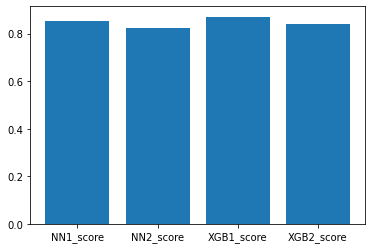

In [46]:
names = list(results.keys())
values = list(results.values())

plt.bar(range(len(results)), values, tick_label=names)
plt.show()

In [50]:
# In this comparison models with their hyperparameters tuned perform worse than models with default hyperparameter values.
# This may be a result of the dataset being small and/ or poor choice of hyperparaneters space